# Imports

In [ ]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
from skimage import io
import cv2
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Embedding

#Utility library
from math import ceil
import matplotlib.pyplot as plt
import matplotlib
# from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import gc
import os

# Dataset

In [ ]:
!wget https://filebox.ece.vt.edu/~vrama91/CIDEr_miscellanous/cider_datasets.tar
!tar -xzvf cider_datasets.tar

--2021-05-14 09:32:12--  https://filebox.ece.vt.edu/~vrama91/CIDEr_miscellanous/cider_datasets.tar
Resolving filebox.ece.vt.edu (filebox.ece.vt.edu)... 128.173.88.43
Connecting to filebox.ece.vt.edu (filebox.ece.vt.edu)|128.173.88.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1680626 (1.6M) [application/x-tar]
Saving to: ‘cider_datasets.tar’

cider_datasets.tar  100%[===================>]   1.60M  --.-KB/s    in 0.08s   

2021-05-14 09:32:12 (19.3 MB/s) - ‘cider_datasets.tar’ saved [1680626/1680626]

Datasets/
Datasets/abstract50S.mat
Datasets/pascal50S.mat


In [ ]:
pascal = loadmat('Datasets/pascal50S.mat')
pascal.keys()

dict_keys(['__header__', '__version__', '__globals__', 'train_sent_final'])

In [ ]:
!gdown --id 1-4zf03wZl4LmbC5aDMkzJSW-jEqWOTCF
!gdown --id 1--zB7YfvyGRIgBrD_8HcNmeHHGJg8Ji9

Downloading...
From: https://drive.google.com/uc?id=1-4zf03wZl4LmbC5aDMkzJSW-jEqWOTCF
To: /content/image_data.npy
188MB [00:01, 97.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--zB7YfvyGRIgBrD_8HcNmeHHGJg8Ji9
To: /content/targets.npy
100% 160k/160k [00:00<00:00, 5.09MB/s]


In [ ]:
targets = np.load("targets.npy")
images = np.load("image_data.npy")
print(targets.shape)
print(images.shape)

(1000, 20)
(1000, 250, 250, 3)


In [ ]:
# import re
# def getWords(text):
#     return re.compile('[A-Za-z]+').findall(text)

data = pascal['train_sent_final']
data = data.flatten()

#extract captions as a list of lists of strings. Each sublist contains 50 captions for the image at the same index as the sublist in the images array
captions = []
for i in range(len(data)):
  data[i][1] = data[i][1].flatten()
  counter = 0
  # captions.append(data[i][1])
  captions.append([])
  for sentence in (data[i][1]):
    if counter >= 50:
      break
    sentence = sentence[0]
    captions[i].append(sentence)
    counter += 1

captions = np.array(captions, dtype=object)

#create a train-test split via shuffling
indices = np.arange(targets.shape[0])
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(indices)

train_slice = int(0.9*targets.shape[0])
train_indices = indices[:train_slice]
test_indices = indices[train_slice:]

train_targets = targets[train_indices]
train_images = images[train_indices]
train_captions = captions[train_indices]

test_targets = targets[test_indices]
test_images = images[test_indices]
test_captions = captions[test_indices]

def flatten_list(x):
  result = []
  for i in x:
    for j in i:
      result.append(j)
  return np.array(result, dtype=object)

#flatten the list of lists of captions to get a list of captions in which the first 50 are captions for the first image, the next 50 for the second image and so on
train_captions = flatten_list(train_captions)

#make a list of indices which represent images in the train_images list corresponding to the captions 
train_dataset_indices = np.array([i//50 for i in range(len(train_captions))])

'''
Our dataset is now essentially like this:
(0, caption1), (0, caption2), ..., (0, caption50), (1, caption 51), ..., (900, caption45000)

The first element just represents the index of the image, so 0 means image 0, 1 means image 1 and so on.
The other element is simply one of the 50 captions of that image.

Representing our dataset like this saves 50x space as the same image does not have to be copied 50 times (once for each caption)
We only make copies of the image when we make a batch of (image, caption) pairs for training.
'''

#shuffle the training dataset thus created

seed = 42
rng = np.random.RandomState(seed)
rng.shuffle(train_dataset_indices)
rng = np.random.RandomState(seed)
rng.shuffle(train_captions)

## Vectorization

In [ ]:
max_vocab_size = 2000 #most words we care about should be found in the most frequent 2000 words
out_seq_length=30 #the longest caption length in the dataset is 37, so the important words usually appear in the first 30 words  

vectorizer = TextVectorization(max_tokens=max_vocab_size, output_sequence_length=out_seq_length)
text_ds = tf.data.Dataset.from_tensor_slices(train_captions).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))#a dictionary that maps a word to an integer between 0-1999

## GloVe

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-05-13 16:58:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-13 16:58:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-13 16:58:35--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!rm glove.6B.100d.txt glove.6B.200d.txt glove.6B.300d.txt

In [ ]:
path_to_glove_file = "glove.6B.50d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
num_tokens = len(voc)
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 1989 words (11 misses)


In [ ]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

# Model

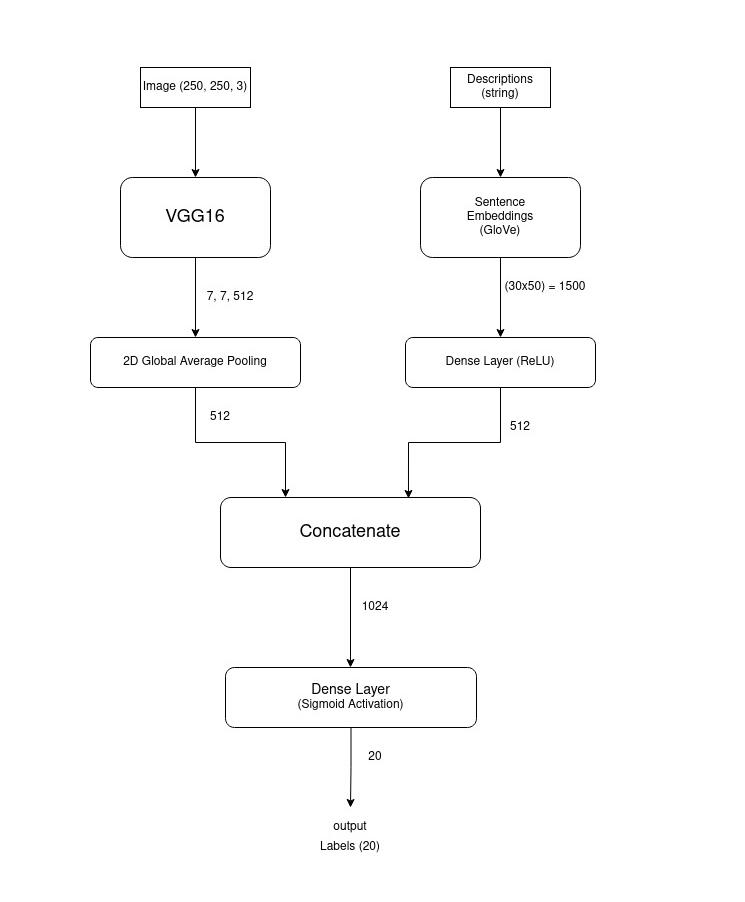

## Text feature generating model

In [ ]:
sentence_feature_nUnits = 512

In [ ]:
def textModel():
  string_input = keras.Input(shape=(1,), dtype="string")
  x = vectorizer(string_input)
  sequence_input = Input(shape=(out_seq_length,), dtype="int64")
  embedded_sequences = embedding_layer(sequence_input)
  feature_extractor = Flatten()(embedded_sequences)
  feature_extractor = Dense(sentence_feature_nUnits, activation="relu")(feature_extractor)
  model1 = Model(sequence_input, feature_extractor)

  model2 = model1(x)
  finalModel = Model(string_input, model2)
  return finalModel

text_model = textModel()
text_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 30)                0         
_________________________________________________________________
model (Functional)           (None, 512)               868512    
Total params: 868,512
Trainable params: 768,512
Non-trainable params: 100,000
_________________________________________________________________


## Image feature generating model

In [ ]:
def vgg16Model():

  baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(250, 250, 3)))

  headModel = baseModel.output
  headModel = GlobalAveragePooling2D()(headModel)
  model = Model(inputs=baseModel.input, outputs=headModel)
  for layer in baseModel.layers:
      layer.trainable = False
  return model

In [ ]:
image_model = vgg16Model()
image_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
____________________________________________________________

In [ ]:
keras.backend.clear_session()
gc.collect()
keras.backend.clear_session()
gc.collect()

95

## Final Model

In [ ]:
def getModel(num_classes, dropout):
  img_model = vgg16Model()
  txt_model = textModel()
  x = concatenate([img_model.output, txt_model.output])
  x = Dropout(dropout)(x)
  out = Dense(num_classes, activation="sigmoid")(x)

  model = Model(inputs=[img_model.input, txt_model.input], outputs=[out])

  return model

# Training

In [ ]:
def data_generator(batch_size):
  train_size = len(train_captions)
  nBatches = train_size//batch_size
  train = np.arange(train_size)
  for i in range(nBatches):
    if (i+1)*batch_size < train_size:
      batch = train[i*batch_size : (i+1)*batch_size]
    else:
      batch = train[i*batch_size:]
    
    captions_batch = train_captions[batch]
    img_batch = train_images[train_dataset_indices[batch]]
    img_batch = preprocess_input(img_batch)
    targets_batch = train_targets[train_dataset_indices[batch]]

    yield ([img_batch, captions_batch], targets_batch)
    

In [ ]:
savefilepath = 'savedMultiModal/cp.ckpt'
class_labels = ['person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train', 'bottle', 'chair', 'table', 'plant', 'sofa', 'monitor']
num_classes = len(class_labels)

In [ ]:
dropout = 0.5
lrate = 3e-3
batch_size = 32
EPOCHS = 10

In [ ]:
model = getModel(num_classes, dropout)
optimizer = Adam(learning_rate=lrate)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=[AUC(multi_label=True), keras.metrics.Precision(), keras.metrics.Recall()])


history = {"auc":[], "precision": [], "recall":[]}
for epoch in range(EPOCHS):
  gen = data_generator(batch_size)
  hist = model.fit(gen, epochs=1, verbose=1)
  hist = hist.history
  history["auc"].append(hist["auc"][0])
  history["precision"].append(hist["precision"][0])
  history["recall"].append(hist["recall"][0])

1406/1406 [==============================] - 245s 175ms/step - loss: 0.1721 - auc: 0.9531 - precision: 0.8268 - recall: 0.8144


# Plots

In [ ]:
#Plot accuracy
def plotMetric(history, metric):
  plt.plot(history[metric])
  plt.title("Model"+" "+metric)
  plt.xlabel("epoch")
  plt.ylabel(metric)
  plt.show()

  print("Best train", metric,":", max(history[metric]))

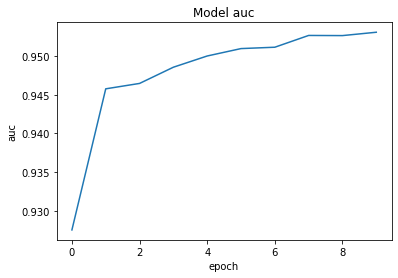

Best train auc : 0.9531024694442749


In [ ]:
plotMetric(history, "auc")

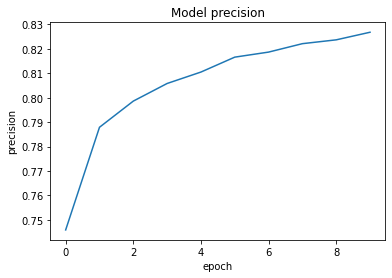

Best train precision : 0.8268210291862488


In [ ]:
plotMetric(history, "precision")

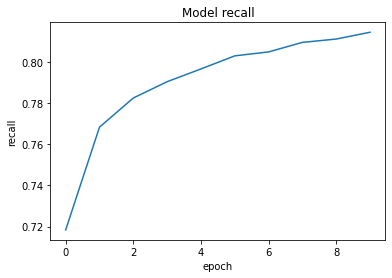

Best train recall : 0.8143755793571472


In [ ]:
plotMetric(history, "recall")

# Testing

In [ ]:
flat_test_captions = flatten_list(test_captions)

test_dataset_indices = np.array([i//50 for i in range(len(flat_test_captions))])

In [ ]:
def test_data_generator(batch_size):

  test_size = len(flat_test_captions)
  nBatches = test_size//batch_size
  test = np.arange(test_size)

  for i in range(nBatches):
    if (i+1)*batch_size < test_size:
      batch = test[i*batch_size : (i+1)*batch_size]
    else:
      batch = test[i*batch_size:]
    captions_batch = flat_test_captions[batch]
    img_batch = test_images[test_dataset_indices[batch]]
    img_batch = preprocess_input(img_batch)
    targets_batch = test_targets[test_dataset_indices[batch]]

    yield ([img_batch, captions_batch], targets_batch)
    

In [ ]:
def getLabels(preds, confidence): #convert labels vectors to class labels
  result = []
  for pred in preds:
    res = []
    for i, prob in enumerate(pred):
      if prob > confidence:
          res.append(class_labels[i])
    result.append(res)
  return result

In [ ]:
imgs = test_images
proc_test_imgs = preprocess_input(imgs)

In [ ]:
def show_output(idx):
  plt.imshow(imgs[idx])
  labs = model.predict([np.array([proc_test_imgs[idx]]), np.array([test_captions[idx][0]])])
  print("Output:",getLabels(labs, 0.5)[0])
  print("Input caption:", test_captions[idx][0])

In [ ]:
test_gen = test_data_generator(64)
model.evaluate(test_gen)

78/78 [==============================] - 68s 301ms/step - loss: 0.5187 - auc_3: 0.8578 - precision_3: 0.7817 - recall_3: 0.6538


[0.5186724662780762,
 0.8578008413314819,
 0.7817203402519226,
 0.6538037657737732]

## Save model to drive

In [ ]:
# model.save("multimodal")
#!cp -r multimodal drive/MyDrive/IITPKD_DL_Project/

# load model from drive

In [ ]:
model = keras.models.load_model("drive/MyDrive/IITPKD_DL_Project/multimodal")

In [15]:
test_gen = test_data_generator(64)
model.evaluate(test_gen)

78/78 [==============================] - 24s 301ms/step - loss: 0.5187 - auc_3: 0.8578 - precision_3: 0.7817 - recall_3: 0.6538


[0.5186724662780762,
 0.8578008413314819,
 0.7817203402519226,
 0.6538037657737732]

Output: ['cow']
Input caption: There are three cows in a field.


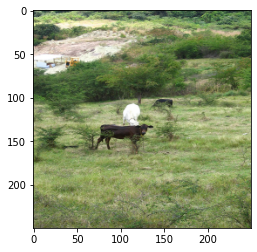

In [ ]:
show_output(0)

Output: ['person', 'chair', 'monitor']
Input caption: A man sitting on a chair, in front of a television, with a laptop on his lap


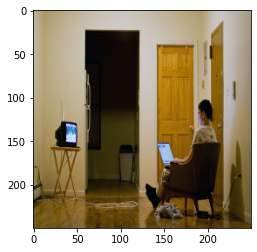

In [ ]:
show_output(10)

Output: ['bicycle', 'bus', 'car', 'motorbike']
Input caption: A bike vendor pulls his cart through traffic.


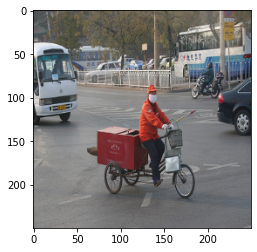

In [ ]:
show_output(34)

Output: ['person', 'bottle']
Input caption: Three men posing with a drinks and a guitar.


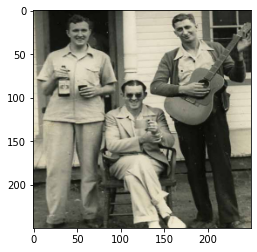

In [ ]:
show_output(4)

Some bad outputs as well

Output: ['person']
Input caption: A horse stares at the camera while another grazes.


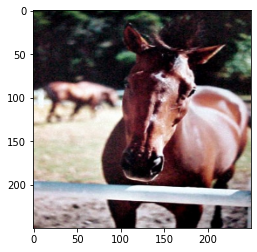

In [ ]:
show_output(8)

Output: []
Input caption: A brightly-painted Rolls Royce sits on display.


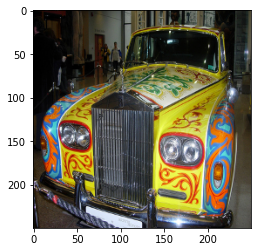

In [ ]:
show_output(1)

And a good output to finish

Output: ['person', 'bicycle', 'plant']
Input caption: A man stands next to a mountain bike.


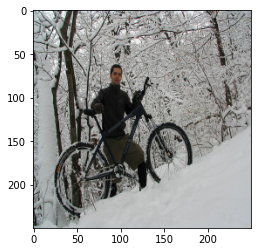

In [ ]:
show_output(63)